## Importação de bibliotecas

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score



## Carregamento do dataset

In [3]:
df = pd.read_feather('../data/carteira_total.feather')


## Data Preparation

### Correção da nomenclatura das colunas

In [4]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(
      re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName


### Criação da variável target

In [5]:
df["upsale_downsale"].replace(
    {"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace(
    {"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)

df.drop(columns=["upsale_downsale"], inplace=True)


### Criação da variável "quantidades mês" (feature engeneering com a variável nativa "mês")

In [6]:
df_grouped = df[['mes', 'id_sap']].groupby(['id_sap']).count().reset_index()

df_grouped.rename(columns = {'mes':'quantidade_mes'}, inplace=True)

In [7]:
df = df.join(df_grouped.set_index('id_sap'), on='id_sap')

### Criação da variável "status_pagamento" (feature engeneering utilizando fonte de dados externa)

In [8]:
xls = pd.ExcelFile('../data/quality_score.xlsx')
xls.sheet_names

i = 0
for data in xls.sheet_names:
    if i == 0:
        dfQuality = pd.read_excel(xls, data)
        dfQuality['data'] = data
        dfQuality.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                  'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)
    else:
        dfQualityAux = pd.read_excel(xls, data)
        dfQualityAux['data'] = data
        dfQualityAux.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                     'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)

        dfQuality = pd.concat([dfQuality, dfQualityAux])

    i+=1

In [9]:
dfQuality['status_pagamento'].replace({'4. Péssimo': 'Pessimo', '2. Regular ': 'Regular', '1. Bom': 'Bom', '3. Ruim': 'Ruim', '5. Novo': 'Novo',
                                       '2. Regular': 'Regular', '1. Bom ': 'Bom', 'lançamentos': np.nan, '5. novo': 'Novo', 0: np.nan}, inplace=True)


In [10]:
dfQuality.dropna(inplace=True)


In [11]:
regex = r'([0-9]{4})-([0-9]{2})-[0-9]{2}'


def fun_replace(data):
    return datetime.datetime.strptime(str(data.group(2)).lower(), '%m').strftime('%b').lower() + data.group(1)[-2:]


df['mes'] = df['mes'].astype(str).str.replace(regex, fun_replace, regex=True)


In [12]:
dfQuality.rename(columns={'ID SAP': 'id_sap', 'data': 'mes'}, inplace=True)


In [13]:
df = df.join(dfQuality.set_index(['id_sap', 'mes']), on=['id_sap', 'mes'])


### Correção dos valores de colunas categóricas

In [14]:
df['oficina'].replace({'wi': 'WI'}, inplace=True)

In [15]:
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()


In [16]:
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()


In [17]:
df['frequencia_de_faturamento'].replace(
    {'única vez': 'unica_vez'}, inplace=True)


In [18]:
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)


### Drop de colunas com valores inutilizáveis

In [19]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)


### Seleção das colunas mais significativas

In [20]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'equipe', 'utilizado_destaque', 'valor_mensal',
         'quantidade_mes', 'status_pagamento', 'churn', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']]


### Drop dos registros cujo o status de pagamento é nulo

In [21]:
df = df[df['status_pagamento'].notna()]


## Modeling

### One hot encode

In [22]:
enc = OneHotEncoder(handle_unknown='ignore')

feature = ['pf_pj', 'equipe', 'status_pagamento', 'regiao',
           'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']

enc.fit(df[feature])

ohe_feature = enc.transform(df[feature]).toarray()
df_ohe = pd.DataFrame(
    ohe_feature, columns=enc.get_feature_names(feature))

df_ohe.index = df.index
df = pd.concat([df, df_ohe], axis=1)

df = df.drop(columns=feature)


### Tratamento de valores faltantes

In [23]:
imputer = SimpleImputer(strategy='median')

imputer.fit(df)

df = pd.DataFrame(imputer.transform(df), columns=df.columns)


### Data split

In [24]:
X = df.drop(['churn'], axis=1)
y = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2


### Tratamento de dados numéricos

In [25]:
def trataDados(df_dados, target):
    # Balanceamento dos dados
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    df_dados, target = sm.fit_resample(df_dados, target.filter(df_dados.index))

    # Normalização dos dados
    numericalColumns = ['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form',
                        'utilizado_destaque', 'valor_mensal', 'quantidade_mes']
    scaler = RobustScaler().fit(df_dados[numericalColumns])
    df_dados[numericalColumns] = scaler.transform(df_dados[numericalColumns])

    return df_dados, target


### Pipeline

In [26]:
# df = df[df['status_pagamento'].notna()]

In [27]:
# numeric_features = ['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'utilizado_destaque', 'valor_mensal', 'quantidade_mes']
# numeric_transformer = Pipeline(
#     steps=[("imputer", SimpleImputer(strategy="median"))]
# )

# categorical_features = ['pf_pj', 'equipe', 'status_pagamento', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']
# categorical_transformer = OneHotEncoder()

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_features),
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )


In [28]:
# numeric_features = ['contratado_ofertas_simples', 'utilizado_ofertas_simples',
#                     'leads_form', 'utilizado_destaque', 'valor_mensal', 'quantidade_mes']
# numeric_transformer = Pipeline(
#     steps=[('scaler', RobustScaler())]
# )

# posprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_features),
#     ]
# )


In [29]:
# clf = Pipeline(
#     steps=[
#         # ("preprocessor", preprocessor),
#         ('sampling', SMOTE(sampling_strategy='minority', random_state=0)),
#         ("posprocessor", posprocessor),
#            ("classifier", MLPClassifier(hidden_layer_sizes=(6, 5),
#                                          random_state=1,
#                                          verbose=True,
#                                          learning_rate_init=0.01))]
# )

# X = df.drop(['churn'], axis=1)
# y = df['churn'].astype(int)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=1)

# clf.fit(X_train, y_train)
# predictDataSet = clf.predict(X_test)

# f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
# accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
# precision = round(precision_score(y_test, predictDataSet)*100, 2)
# recall = round(recall_score(y_test, predictDataSet)*100, 2)

# print(f"F1 Score: {f1}%")
# print(f"Accuracy Score: {accuracy}%")
# print(f"Precision Score: {precision}%")
# print(f"Recall Score: {recall}%")

# plot_confusion_matrix(clf, X_test, y_test, display_labels=[
#     "positivo", "negativo"], values_format="d")
# plt.grid(False)
# plt.show()

# plot_roc_curve(clf, X_test, y_test)
# plt.show()


### Execução do Modelo

In [30]:
X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)

In [31]:
def executeModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y=y_train)

    y_pred = model.predict(X_test)

    f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    precision = round(precision_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred)*100, 2)

    print(f"F1 Score: {f1}%")
    print(f"Accuracy Score: {accuracy}%")
    print(f"Precision Score: {precision}%")
    print(f"Recall Score: {recall}%")

    plot_confusion_matrix(model, X_test, y_test, display_labels=[
        "positivo", "negativo"], values_format="d")


Multilayer Perceptron
------------------------------
F1 Score: 87.29%
Accuracy Score: 87.29%
Precision Score: 87.31%
Recall Score: 87.26%


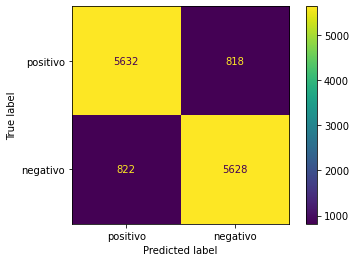

In [32]:
print('Multilayer Perceptron')
print('-' * 30)
executeModel(MLPClassifier(hidden_layer_sizes=(6, 5),
                           random_state=42,
                           learning_rate_init=0.01), X_train, y_train, X_val, y_val)
